# Tensorflow Object Detection API and AWS Sagemaker

In [1]:
# EfficientDet_D1_640x640.config

In this notebook, you will train and evaluate different models using the [Tensorflow Object Detection API](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/) and [AWS Sagemaker](https://aws.amazon.com/sagemaker/). 

If you ever feel stuck, you can refer to this [tutorial](https://aws.amazon.com/blogs/machine-learning/training-and-deploying-models-using-tensorflow-2-with-the-object-detection-api-on-amazon-sagemaker/).

## Dataset

We are using the [Waymo Open Dataset](https://waymo.com/open/) for this project. The dataset has already been exported using the tfrecords format. The files have been created following the format described [here](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#create-tensorflow-records). You can find data stored on [AWS S3](https://aws.amazon.com/s3/), AWS Object Storage. The images are saved with a resolution of 640x640.

In [2]:
%%capture
%pip install tensorflow_io sagemaker -U

In [3]:
import os
import sagemaker
from sagemaker.estimator import Estimator
from framework import CustomFramework

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Save the IAM role in a variable called `role`. This would be useful when training the model.

In [4]:
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::359346771395:role/service-role/AmazonSageMaker-ExecutionRole-20240516T125452


In [5]:
# The train and val paths below are public S3 buckets created by Udacity for this project
inputs = {'train': 's3://cd2688-object-detection-tf2/train/', 
          'val': 's3://cd2688-object-detection-tf2/val/'} 

# Insert path of a folder in your personal S3 bucket to store tensorboard logs.
tensorboard_s3_prefix = 's3://udacity-selfdriving-240516-1358/logs/'

## Container

To train the model, you will first need to build a [docker](https://www.docker.com/) container with all the dependencies required by the TF Object Detection API. The code below does the following:
* clone the Tensorflow models repository
* get the exporter and training scripts from the repository
* build the docker image and push it 
* print the container name

In [6]:
%%bash

# clone the repo and get the scripts
# git clone https://github.com/tensorflow/models.git docker/models

# get model_main and exporter_main files from TF2 Object Detection GitHub repository
# cp docker/models/research/object_detection/exporter_main_v2.py source_dir 
# cp docker/models/research/object_detection/model_main_tf2.py source_dir

In [7]:
# build and push the docker image. This code can be commented out after being run once.
# This will take around 10 mins.

#image_name = 'tf2-object-detection'
#!sh ./docker/build_and_push.sh $image_name

To verify that the image was correctly pushed to the [Elastic Container Registry](https://aws.amazon.com/ecr/), you can look at it in the AWS webapp. For example, below you can see that three different images have been pushed to ECR. You should only see one, called `tf2-object-detection`.
![ECR Example](../data/example_ecr.png)


In [8]:
# display the container name
with open (os.path.join('docker', 'ecr_image_fullname.txt'), 'r') as f:
    container = f.readlines()[0][:-1]

print(container)

359346771395.dkr.ecr.us-east-1.amazonaws.com/tf2-object-detection:20240527120237


## Pre-trained model from model zoo

As often, we are not training from scratch and we will be using a pretrained model from the TF Object Detection model zoo. You can find pretrained checkpoints [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Because your time is limited for this project, we recommend to only experiment with the following models:
* SSD MobileNet V2 FPNLite 640x640	
* SSD ResNet50 V1 FPN 640x640 (RetinaNet50)	
* Faster R-CNN ResNet50 V1 640x640	
* EfficientDet D1 640x640	
* Faster R-CNN ResNet152 V1 640x640	

In the code below, the EfficientDet D1 model is downloaded and extracted. This code should be adjusted if you were to experiment with other architectures.

In [9]:
%%bash
pwd
rm -r /tmp/checkpoint
rm -r source_dir/checkpoint
mkdir /tmp/checkpoint
mkdir source_dir/checkpoint

#EfficientDet_D1_640x640
wget -O /tmp/efficientdet.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz
tar -zxvf /tmp/efficientdet.tar.gz --strip-components 2 --directory source_dir/checkpoint efficientdet_d1_coco17_tpu-32/checkpoint

#ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8
#wget -O /tmp/ssdmobilenet.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
#tar -zxvf /tmp/ssdmobilenet.tar.gz --strip-components 2 --directory source_dir/checkpoint ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint
# result out of memory with pipeline_ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config

#Faster R-CNN ResNet152 V1 640x640
#wget -O /tmp/fasterrcnn.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz
#tar -zxvf /tmp/fasterrcnn.tar.gz --strip-components 2 --directory source_dir/checkpoint faster_rcnn_resnet152_v1_640x640_coco17_tpu-8/checkpoint

#SSD ResNet50 V1 FPN 640x640 (RetinaNet50)
#wget -O /tmp/ssdresnet50.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
#tar -zxvf /tmp/ssdresnet50.tar.gz --strip-components 2 --directory source_dir/checkpoint ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint

#Faster R-CNN ResNet50 V1 640x640
#wget -O /tmp/fasterrcnn50.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
#tar -zxvf /tmp/fasterrcnn50.tar.gz --strip-components 2 --directory source_dir/checkpoint faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint


/home/ec2-user/SageMaker/cd2688-object-detection-in-urban-environment-project/1_model_training


--2024-06-06 13:59:40--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.167.207, 172.253.62.207, 172.253.115.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.167.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51839363 (49M) [application/x-tar]
Saving to: ‘/tmp/efficientdet.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 11.6M 4s
    50K .......... .......... .......... .......... ..........  0% 24.4M 3s
   100K .......... .......... .......... .......... ..........  0% 23.8M 3s
   150K .......... .......... .......... .......... ..........  0% 17.9M 3s
   200K .......... .......... .......... .......... ..........  0% 24.4M 3s
   250K .......... .......... .......... .......... ..........  0% 24.7M 3s
   300K .......... .......... .......... .......... ..........  0% 28.

  5100K .......... .......... .......... .......... .......... 10% 39.1M 1s
  5150K .......... .......... .......... .......... .......... 10% 39.1M 1s
  5200K .......... .......... .......... .......... .......... 10% 55.0M 1s
  5250K .......... .......... .......... .......... .......... 10%  104M 1s
  5300K .......... .......... .......... .......... .......... 10% 44.3M 1s
  5350K .......... .......... .......... .......... .......... 10% 49.2M 1s
  5400K .......... .......... .......... .......... .......... 10% 46.5M 1s
  5450K .......... .......... .......... .......... .......... 10%  340M 1s
  5500K .......... .......... .......... .......... .......... 10% 43.6M 1s
  5550K .......... .......... .......... .......... .......... 11% 46.1M 1s
  5600K .......... .......... .......... .......... .......... 11% 45.5M 1s
  5650K .......... .......... .......... .......... .......... 11% 40.7M 1s
  5700K .......... .......... .......... .......... .......... 11%  394M 1s
  5750K ....

 10500K .......... .......... .......... .......... .......... 20%  101M 1s
 10550K .......... .......... .......... .......... .......... 20% 92.0M 1s
 10600K .......... .......... .......... .......... .......... 21%  230M 1s
 10650K .......... .......... .......... .......... .......... 21% 84.3M 1s
 10700K .......... .......... .......... .......... .......... 21%  106M 1s
 10750K .......... .......... .......... .......... .......... 21% 98.4M 1s
 10800K .......... .......... .......... .......... .......... 21% 88.5M 1s
 10850K .......... .......... .......... .......... .......... 21%  236M 1s
 10900K .......... .......... .......... .......... .......... 21%  100M 1s
 10950K .......... .......... .......... .......... .......... 21% 88.2M 1s
 11000K .......... .......... .......... .......... .......... 21% 92.9M 1s
 11050K .......... .......... .......... .......... .......... 21% 93.8M 1s
 11100K .......... .......... .......... .......... .......... 22%  151M 1s
 11150K ....

 15900K .......... .......... .......... .......... .......... 31%  170M 1s
 15950K .......... .......... .......... .......... .......... 31%  255M 1s
 16000K .......... .......... .......... .......... .......... 31%  130M 1s
 16050K .......... .......... .......... .......... .......... 31% 81.1M 1s
 16100K .......... .......... .......... .......... .......... 31%  232M 1s
 16150K .......... .......... .......... .......... .......... 32%  120M 1s
 16200K .......... .......... .......... .......... .......... 32%  317M 1s
 16250K .......... .......... .......... .......... .......... 32% 96.8M 1s
 16300K .......... .......... .......... .......... .......... 32%  134M 1s
 16350K .......... .......... .......... .......... .......... 32%  106M 1s
 16400K .......... .......... .......... .......... .......... 32%  232M 1s
 16450K .......... .......... .......... .......... .......... 32% 95.6M 1s
 16500K .......... .......... .......... .......... .......... 32%  307M 1s
 16550K ....

 21300K .......... .......... .......... .......... .......... 42%  212M 0s
 21350K .......... .......... .......... .......... .......... 42%  196M 0s
 21400K .......... .......... .......... .......... .......... 42%  234M 0s
 21450K .......... .......... .......... .......... .......... 42%  338M 0s
 21500K .......... .......... .......... .......... .......... 42%  183M 0s
 21550K .......... .......... .......... .......... .......... 42%  188M 0s
 21600K .......... .......... .......... .......... .......... 42%  229M 0s
 21650K .......... .......... .......... .......... .......... 42%  205M 0s
 21700K .......... .......... .......... .......... .......... 42%  218M 0s
 21750K .......... .......... .......... .......... .......... 43%  216M 0s
 21800K .......... .......... .......... .......... .......... 43%  210M 0s
 21850K .......... .......... .......... .......... .......... 43%  341M 0s
 21900K .......... .......... .......... .......... .......... 43%  219M 0s
 21950K ....

 26700K .......... .......... .......... .......... .......... 52%  255M 0s
 26750K .......... .......... .......... .......... .......... 52%  287M 0s
 26800K .......... .......... .......... .......... .......... 53%  234M 0s
 26850K .......... .......... .......... .......... .......... 53%  231M 0s
 26900K .......... .......... .......... .......... .......... 53%  212M 0s
 26950K .......... .......... .......... .......... .......... 53%  176M 0s
 27000K .......... .......... .......... .......... .......... 53%  289M 0s
 27050K .......... .......... .......... .......... .......... 53%  339M 0s
 27100K .......... .......... .......... .......... .......... 53%  204M 0s
 27150K .......... .......... .......... .......... .......... 53%  220M 0s
 27200K .......... .......... .......... .......... .......... 53%  260M 0s
 27250K .......... .......... .......... .......... .......... 53%  336M 0s
 27300K .......... .......... .......... .......... .......... 54%  187M 0s
 27350K ....

 32100K .......... .......... .......... .......... .......... 63%  320M 0s
 32150K .......... .......... .......... .......... .......... 63%  275M 0s
 32200K .......... .......... .......... .......... .......... 63%  313M 0s
 32250K .......... .......... .......... .......... .......... 63%  333M 0s
 32300K .......... .......... .......... .......... .......... 63%  343M 0s
 32350K .......... .......... .......... .......... .......... 64%  274M 0s
 32400K .......... .......... .......... .......... .......... 64%  321M 0s
 32450K .......... .......... .......... .......... .......... 64%  335M 0s
 32500K .......... .......... .......... .......... .......... 64%  309M 0s
 32550K .......... .......... .......... .......... .......... 64%  295M 0s
 32600K .......... .......... .......... .......... .......... 64%  343M 0s
 32650K .......... .......... .......... .......... .......... 64%  346M 0s
 32700K .......... .......... .......... .......... .......... 64%  291M 0s
 32750K ....

 37500K .......... .......... .......... .......... .......... 74%  404M 0s
 37550K .......... .......... .......... .......... .......... 74%  400M 0s
 37600K .......... .......... .......... .......... .......... 74%  410M 0s
 37650K .......... .......... .......... .......... .......... 74%  328M 0s
 37700K .......... .......... .......... .......... .......... 74%  336M 0s
 37750K .......... .......... .......... .......... .......... 74%  335M 0s
 37800K .......... .......... .......... .......... .......... 74%  490M 0s
 37850K .......... .......... .......... .......... .......... 74%  367M 0s
 37900K .......... .......... .......... .......... .......... 74%  366M 0s
 37950K .......... .......... .......... .......... .......... 75%  358M 0s
 38000K .......... .......... .......... .......... .......... 75%  295M 0s
 38050K .......... .......... .......... .......... .......... 75%  289M 0s
 38100K .......... .......... .......... .......... .......... 75%  403M 0s
 38150K ....

 42900K .......... .......... .......... .......... .......... 84%  333M 0s
 42950K .......... .......... .......... .......... .......... 84%  283M 0s
 43000K .......... .......... .......... .......... .......... 85%  257M 0s
 43050K .......... .......... .......... .......... .......... 85%  304M 0s
 43100K .......... .......... .......... .......... .......... 85%  298M 0s
 43150K .......... .......... .......... .......... .......... 85%  286M 0s
 43200K .......... .......... .......... .......... .......... 85%  328M 0s
 43250K .......... .......... .......... .......... .......... 85%  290M 0s
 43300K .......... .......... .......... .......... .......... 85%  339M 0s
 43350K .......... .......... .......... .......... .......... 85%  292M 0s
 43400K .......... .......... .......... .......... .......... 85%  318M 0s
 43450K .......... .......... .......... .......... .......... 85%  295M 0s
 43500K .......... .......... .......... .......... .......... 86%  278M 0s
 43550K ....

 48300K .......... .......... .......... .......... .......... 95%  280M 0s
 48350K .......... .......... .......... .......... .......... 95%  279M 0s
 48400K .......... .......... .......... .......... .......... 95%  308M 0s
 48450K .......... .......... .......... .......... .......... 95%  292M 0s
 48500K .......... .......... .......... .......... .......... 95%  334M 0s
 48550K .......... .......... .......... .......... .......... 96%  269M 0s
 48600K .......... .......... .......... .......... .......... 96%  320M 0s
 48650K .......... .......... .......... .......... .......... 96%  293M 0s
 48700K .......... .......... .......... .......... .......... 96%  301M 0s
 48750K .......... .......... .......... .......... .......... 96%  262M 0s
 48800K .......... .......... .......... .......... .......... 96%  325M 0s
 48850K .......... .......... .......... .......... .......... 96%  307M 0s
 48900K .......... .......... .......... .......... .......... 96%  303M 0s
 48950K ....

efficientdet_d1_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d1_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d1_coco17_tpu-32/checkpoint/ckpt-0.index


## Edit pipeline.config file

The [`pipeline.config`](source_dir/pipeline.config) in the `source_dir` folder should be updated when you experiment with different models. The different config files are available [here](https://github.com/tensorflow/models/tree/master/research/object_detection/configs/tf2).

>Note: The provided `pipeline.config` file works well with the `EfficientDet` model. You would need to modify it when working with other models.

## Launch Training Job

Now that we have a dataset, a docker image and some pretrained model weights, we can launch the training job. To do so, we create a [Sagemaker Framework](https://sagemaker.readthedocs.io/en/stable/frameworks/index.html), where we indicate the container name, name of the config file, number of training steps etc.

The `run_training.sh` script does the following:
* train the model for `num_train_steps` 
* evaluate over the val dataset
* export the model

Different metrics will be displayed during the evaluation phase, including the mean average precision. These metrics can be used to quantify your model performances and compare over the different iterations.

You can also monitor the training progress by navigating to **Training -> Training Jobs** from the Amazon Sagemaker dashboard in the Web UI.

In [ ]:
tensorboard_output_config = sagemaker.debugger.TensorBoardOutputConfig(
    s3_output_path=tensorboard_s3_prefix,
    container_local_output_path='/opt/training/'
)

estimator = CustomFramework(
    role=role,
    image_uri=container,
    entry_point='run_training.sh',
    source_dir='source_dir/',
    hyperparameters={
        "model_dir": "/opt/training",        
        "pipeline_config_path": "EfficientDet_D1_640x640.config",
        "num_train_steps": "2000",    
        "sample_1_of_n_eval_examples": "1"
    },
    instance_count=1,
    instance_type='ml.g5.xlarge', # ml.g5.xlarge
    tensorboard_output_config=tensorboard_output_config,
    disable_profiler=True,
    base_job_name='tf2-object-detection'
)

estimator.fit(inputs)

INFO:sagemaker:Creating training-job with name: tf2-object-detection-2024-06-06-13-59-42-073


2024-06-06 13:59:44 Starting - Starting the training job...
2024-06-06 14:00:02 Starting - Preparing the instances for training...
2024-06-06 14:00:33 Downloading - Downloading input data...
2024-06-06 14:00:53 Downloading - Downloading the training image.........
2024-06-06 14:02:39 Training - Training image download completed. Training in progress...2024-06-06 14:02:48,093 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-06-06 14:02:48,128 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-06-06 14:02:48,163 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-06-06 14:02:48,179 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train",
        "val": "/opt/ml/input/data/val"
    },
    "current_host": "algo-1",
    "current_inst

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0606 14:03:05.435065 140016717588288 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use `tf.cast` instead.
W0606 14:03:09.051164 140016717588288 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
/usr/local/lib/python3.8/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/Fa

INFO:tensorflow:Step 300 per-step time 0.692s
I0606 14:08:14.223862 140016717588288 model_lib_v2.py:705] Step 300 per-step time 0.692s
INFO:tensorflow:{'Loss/classification_loss': 0.2707652,
 'Loss/localization_loss': 0.015589998,
 'Loss/regularization_loss': 0.029550593,
 'Loss/total_loss': 0.31590578,
 'learning_rate': 0.010480001}
I0606 14:08:14.224140 140016717588288 model_lib_v2.py:708] {'Loss/classification_loss': 0.2707652,
 'Loss/localization_loss': 0.015589998,
 'Loss/regularization_loss': 0.029550593,
 'Loss/total_loss': 0.31590578,
 'learning_rate': 0.010480001}
INFO:tensorflow:Step 400 per-step time 0.692s
I0606 14:09:23.472634 140016717588288 model_lib_v2.py:705] Step 400 per-step time 0.692s
INFO:tensorflow:{'Loss/classification_loss': 0.35819042,
 'Loss/localization_loss': 0.021857072,
 'Loss/regularization_loss': 0.02955733,
 'Loss/total_loss': 0.40960482,
 'learning_rate': 0.0136400005}
I0606 14:09:23.472878 140016717588288 model_lib_v2.py:708] {'Loss/classification_lo

INFO:tensorflow:Step 1900 per-step time 0.693s
I0606 14:26:44.996914 140016717588288 model_lib_v2.py:705] Step 1900 per-step time 0.693s
INFO:tensorflow:{'Loss/classification_loss': 0.25004458,
 'Loss/localization_loss': 0.01197494,
 'Loss/regularization_loss': 0.030559527,
 'Loss/total_loss': 0.29257905,
 'learning_rate': 0.06104}
I0606 14:26:44.997158 140016717588288 model_lib_v2.py:708] {'Loss/classification_loss': 0.25004458,
 'Loss/localization_loss': 0.01197494,
 'Loss/regularization_loss': 0.030559527,
 'Loss/total_loss': 0.29257905,
 'learning_rate': 0.06104}
INFO:tensorflow:Step 2000 per-step time 0.693s
I0606 14:27:54.248186 140016717588288 model_lib_v2.py:705] Step 2000 per-step time 0.693s
INFO:tensorflow:{'Loss/classification_loss': 0.21156532,
 'Loss/localization_loss': 0.008129729,
 'Loss/regularization_loss': 0.03071463,
 'Loss/total_loss': 0.25040966,
 'learning_rate': 0.06420001}
I0606 14:27:54.248431 140016717588288 model_lib_v2.py:708] {'Loss/classification_loss': 0

Instructions for updating:
Use `tf.cast` instead.
W0606 14:28:12.404692 140488954169152 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Waiting for new checkpoint at /opt/training
I0606 14:28:14.751301 140488954169152 checkpoint_utils.py:168] Waiting for new checkpoint at /opt/training
INFO:tensorflow:Found new checkpoint at /opt/training/ckpt-3
I0606 14:28:14.751903 140488954169152 checkpoint_utils.py:177] Found new checkpoint at /opt/training/ckpt-3
/usr/local/lib/python3.8/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
I0606 14:28:2

I0606 14:33:28.535386 140189829408576 efficientnet_model.py:143] round_filter input=16 output=16
I0606 14:33:28.535537 140189829408576 efficientnet_model.py:143] round_filter input=24 output=24
I0606 14:33:28.770246 140189829408576 efficientnet_model.py:143] round_filter input=24 output=24
I0606 14:33:28.770407 140189829408576 efficientnet_model.py:143] round_filter input=40 output=40
I0606 14:33:29.003716 140189829408576 efficientnet_model.py:143] round_filter input=40 output=40
I0606 14:33:29.003848 140189829408576 efficientnet_model.py:143] round_filter input=80 output=80
I0606 14:33:29.303474 140189829408576 efficientnet_model.py:143] round_filter input=80 output=80
I0606 14:33:29.303609 140189829408576 efficientnet_model.py:143] round_filter input=112 output=112
I0606 14:33:29.610289 140189829408576 efficientnet_model.py:143] round_filter input=112 output=112
I0606 14:33:29.610442 140189829408576 efficientnet_model.py:143] round_filter input=192 output=192
I0606 14:33:29.992193 14

In [ ]:
# DEBUG / TROUBLESHOOT
#ls /tmp/checkpoint
#mkdir source_dir/checkpoint

import os

# Get the current working directory
current_directory = os.getcwd()
print(current_directory)

# Extract the directory name
directory_name = os.path.basename(current_directory)

# Print the directory name
print(directory_name)

files = [f for f in os.listdir('/home/ec2-user/SageMaker/cd2688-object-detection-in-urban-environment-project/1_model_training/source_dir/checkpoint')]
for f in files:
    print(f)
    # do something

print("\n/opt")
files = [f for f in os.listdir('/opt/')]
for f in files:
    print(f)
    # do something

    
# /home/ec2-user/SageMaker/cd2688-object-detection-in-urban-environment-project/1_model_training/source_dir

/home/ec2-user/SageMaker/cd2688-object-detection-in-urban-environment-project/1_model_training
1_model_training
ckpt-0.data-00000-of-00001
checkpoint
ckpt-0.index

/opt
aws
rh
containerd
amazon
aws-ofi-nccl
install-rootless-docker.sh
lib
brazil-npm-registry
docker.tgz
rootless.tgz
.sagemaker
ml


You should be able to see your model training in the AWS webapp as shown below:
![ECR Example](../data/example_trainings.png)


## Improve on the initial model

Most likely, this initial experiment did not yield optimal results. However, you can make multiple changes to the `pipeline.config` file to improve this model. One obvious change consists in improving the data augmentation strategy. The [`preprocessor.proto`](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto) file contains the different data augmentation method available in the Tf Object Detection API. Justify your choices of augmentations in the write-up.

Keep in mind that the following are also available:
* experiment with the optimizer: type of optimizer, learning rate, scheduler etc
* experiment with the architecture. The Tf Object Detection API model zoo offers many architectures. Keep in mind that the pipeline.config file is unique for each architecture and you will have to edit it.
* visualize results on the test frames using the `2_deploy_model` notebook available in this repository.

In the cell below, write down all the different approaches you have experimented with, why you have chosen them and what you would have done if you had more time and resources. Justify your choices using the tensorboard visualizations (take screenshots and insert them in your write-up), the metrics on the evaluation set and the generated animation you have created with [this tool](../2_run_inference/2_deploy_model.ipynb).

# your write-up goes here.
This model is the default setup provided with the exercise.
## default configuration
Mean average prevision (mAP) was:
* mAP: 0.03154
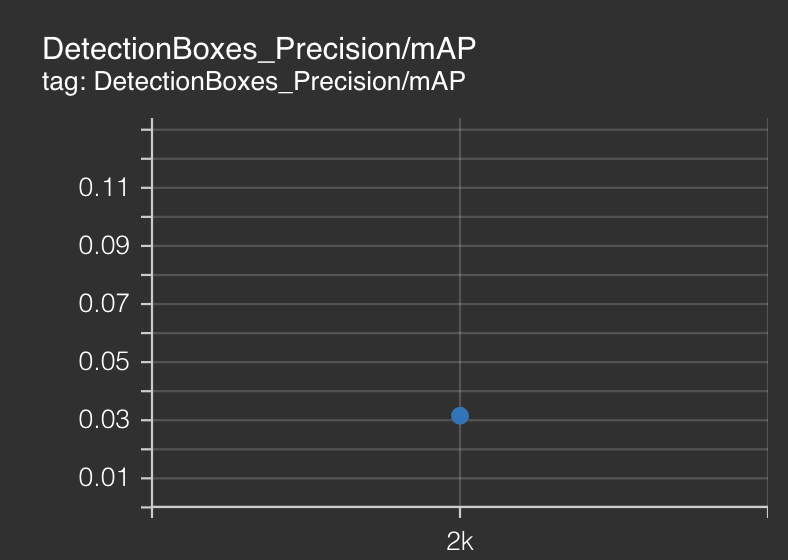






Evaluating the model it is clear that the evaluate results have much higher loss than during training, suggesting substantial overfitting:
* total loss in training: 0.8933
* ... in evaluation: 1,495
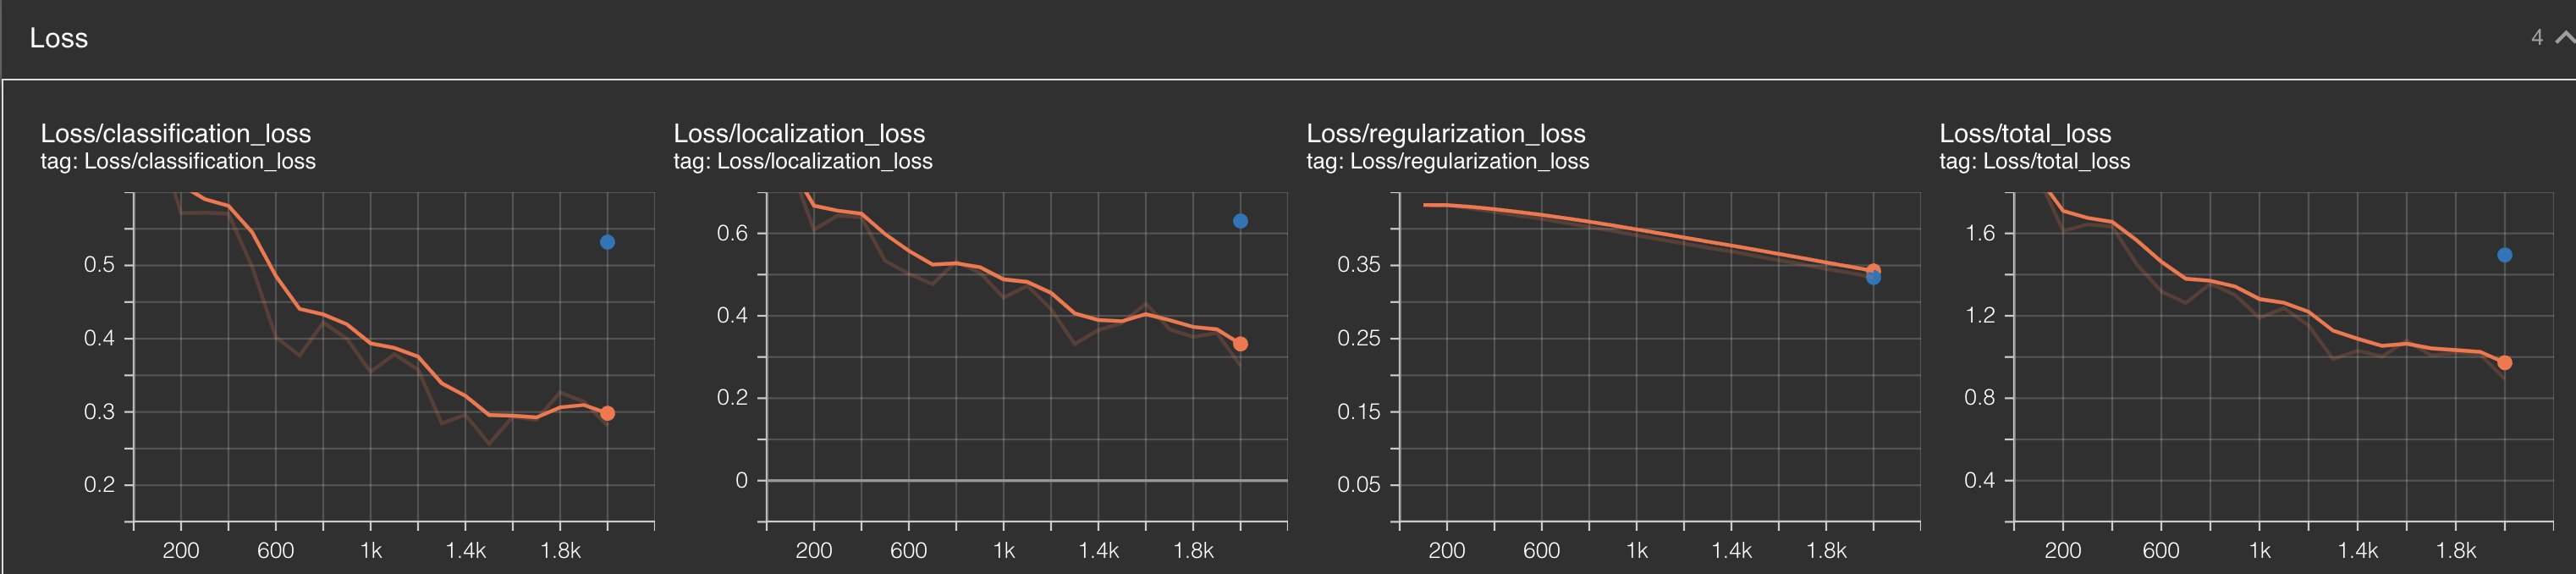

learning rate
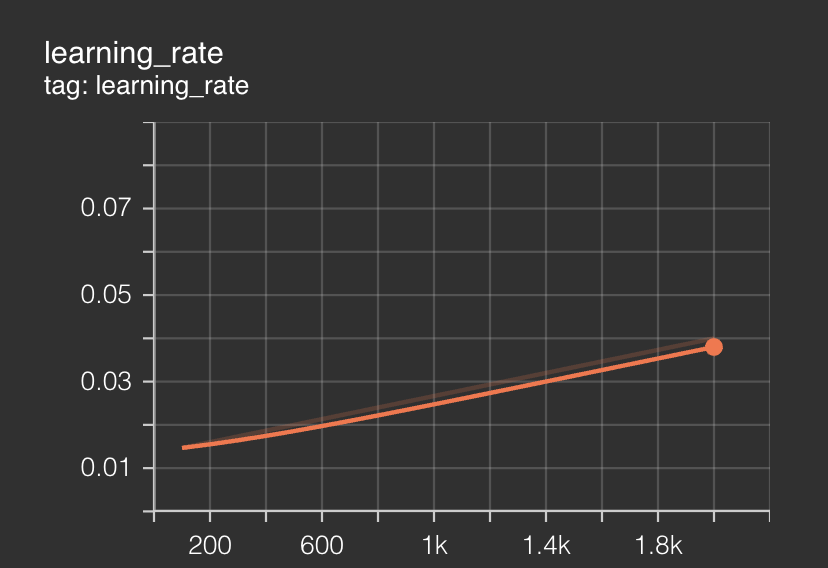